In [ ]:
from google.colab import auth, files
auth.authenticate_user()
print("Authenticated")

Authenticated


In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project="btcproject-480223")

query = """SELECT * FROM  `btcproject-480223.BTCData.bitcoin_history`"""
data = client.query(query).to_dataframe()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4096 entries, 0 to 4095
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4096 non-null   dbdate 
 1   Close   4096 non-null   float64
 2   High    4096 non-null   float64
 3   Low     4096 non-null   float64
 4   Open    4096 non-null   float64
 5   Volume  4096 non-null   Int64  
dtypes: Int64(1), dbdate(1), float64(4)
memory usage: 196.1 KB


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Basic Structure & Data Quality
print("Shape:", data.shape)
print("\nData types:")
print(data.dtypes)

print("\nMissing values:")
print(data.isna().sum())

print("\nSummary statistics:")
data.describe().T

Shape: (4096, 6)

Data types:
Date       dbdate
Close     float64
High      float64
Low       float64
Open      float64
Volume      Int64
dtype: object

Missing values:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Summary statistics:


,count,mean,std,min,25%,50%,75%,max
Close,4096.0,26425.05375,31339.854574,178.102997,2608.679993,10611.929199,41620.353516,124752.53125
High,4096.0,26937.571815,31864.642094,211.731003,2749.389954,10884.02832,42478.631836,126198.070312
Low,4096.0,25838.057322,30749.229106,171.509995,2536.247559,10300.467285,40664.043945,123196.046875
Open,4096.0,26403.38258,31325.714273,176.897003,2607.887573,10600.151855,41555.605469,124752.140625
Volume,4096.0,21474923755.623291,22839183005.11087,5914570.0,1206027488.0,16959926065.0,32881077728.25,350967941479.0


In [ ]:
# Ensure datetime and sort
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date").reset_index(drop=True)

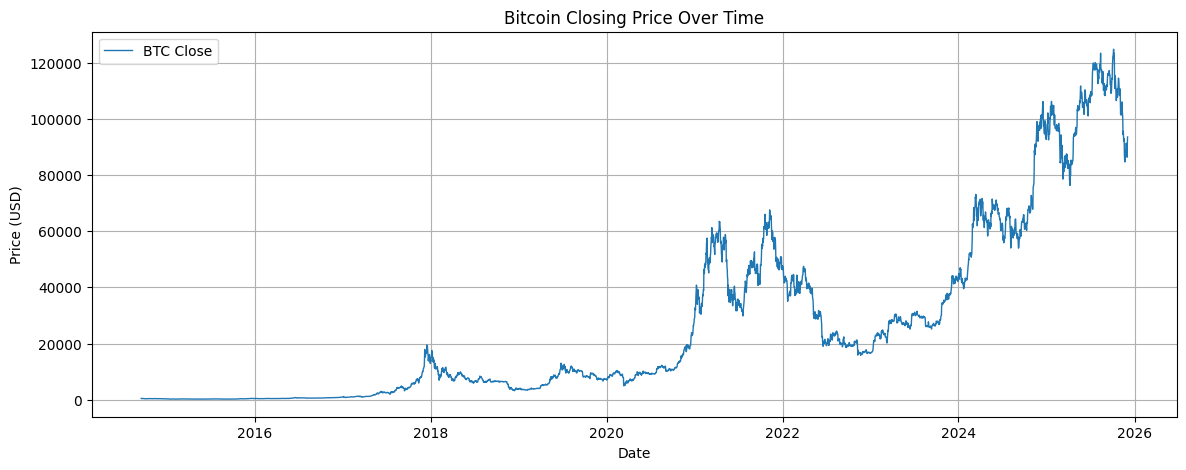

In [ ]:
# Plot Close Price Over Time

plt.figure(figsize=(14, 5))
plt.plot(data["Date"], data["Close"], label="BTC Close", linewidth=1.0)
plt.title("Bitcoin Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

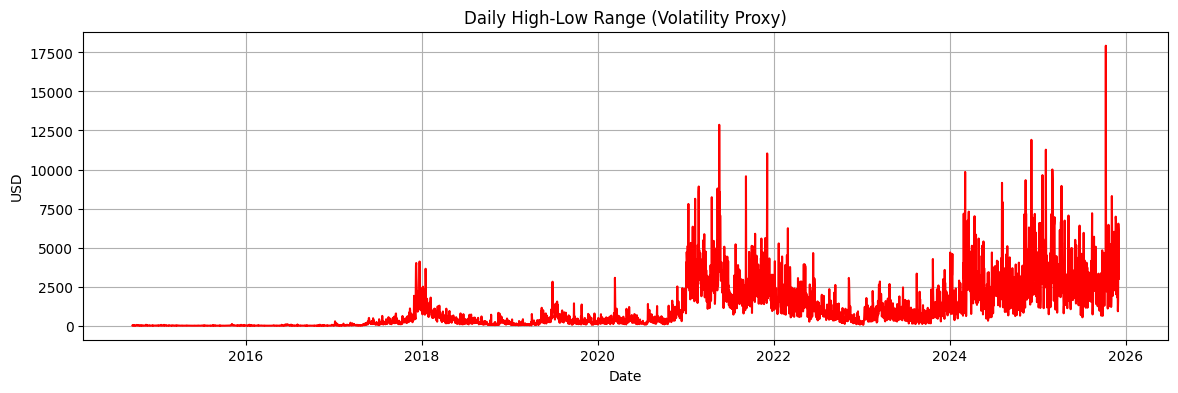

In [ ]:
# Plot High–Low Range (Market Volatility) Over Time
data["range_HL"] = data["High"] - data["Low"]

plt.figure(figsize=(14,4))
plt.plot(data["Date"], data["range_HL"], color="red")
plt.title("Daily High-Low Range (Volatility Proxy)")
plt.xlabel("Date")
plt.ylabel("USD")
plt.grid(True)
plt.show()

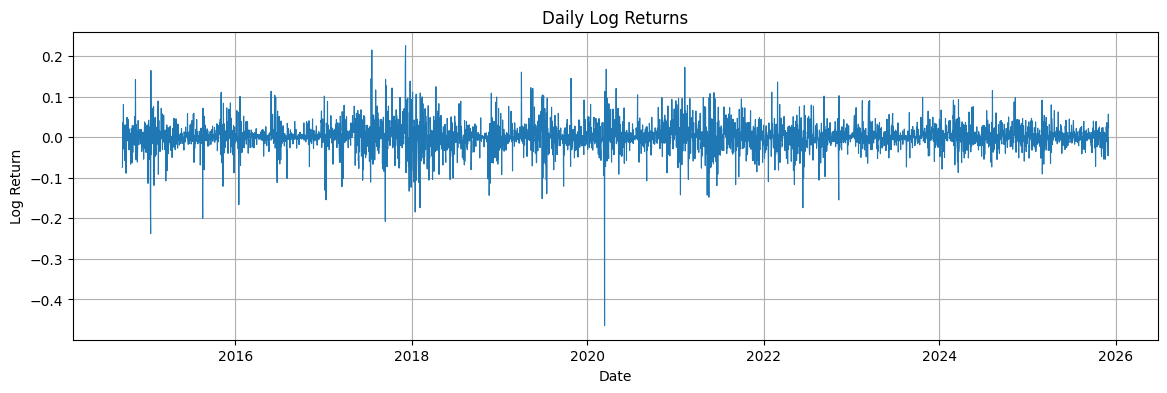

In [ ]:
# Log Returns & Distribution
data["log_return"] = np.log(data["Close"] / data["Close"].shift(1))

plt.figure(figsize=(14,4))
plt.plot(data["Date"], data["log_return"], linewidth=0.8)
plt.title("Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()

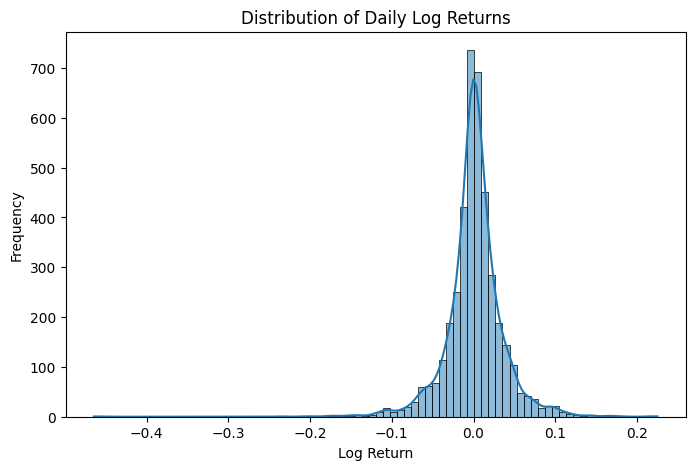

In [ ]:
# Histogram & KDE:
plt.figure(figsize=(8,5))
sns.histplot(data["log_return"].dropna(), bins=80, kde=True)
plt.title("Distribution of Daily Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()

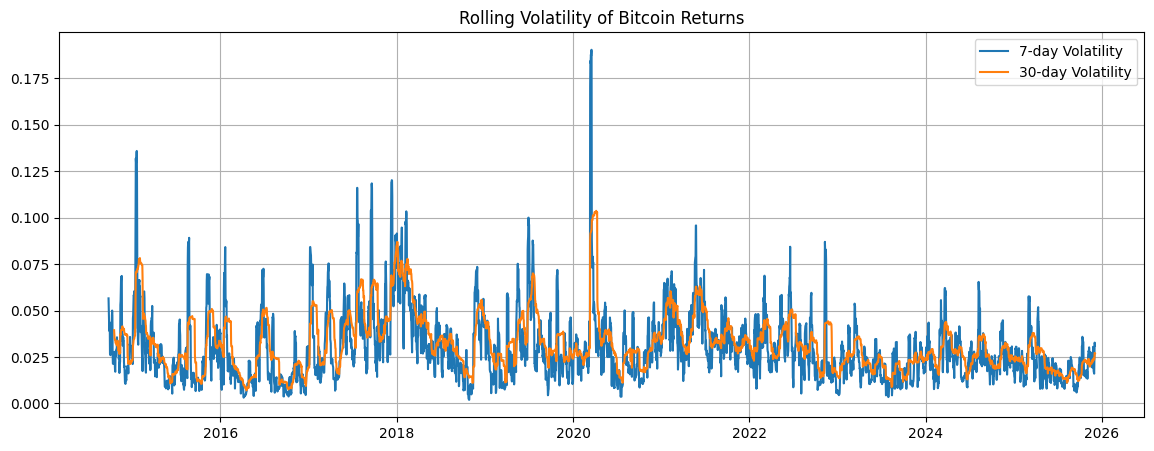

In [ ]:
# Rolling Volatility (7-day, 30-day)
data["vol_7"] = data["log_return"].rolling(7).std()
data["vol_30"] = data["log_return"].rolling(30).std()

plt.figure(figsize=(14,5))
plt.plot(data["Date"], data["vol_7"], label="7-day Volatility")
plt.plot(data["Date"], data["vol_30"], label="30-day Volatility")
plt.title("Rolling Volatility of Bitcoin Returns")
plt.legend()
plt.grid(True)
plt.show()

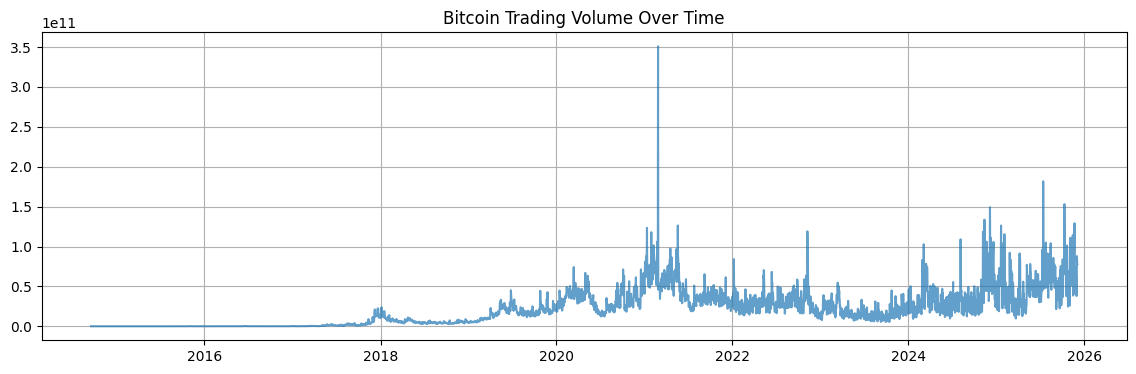

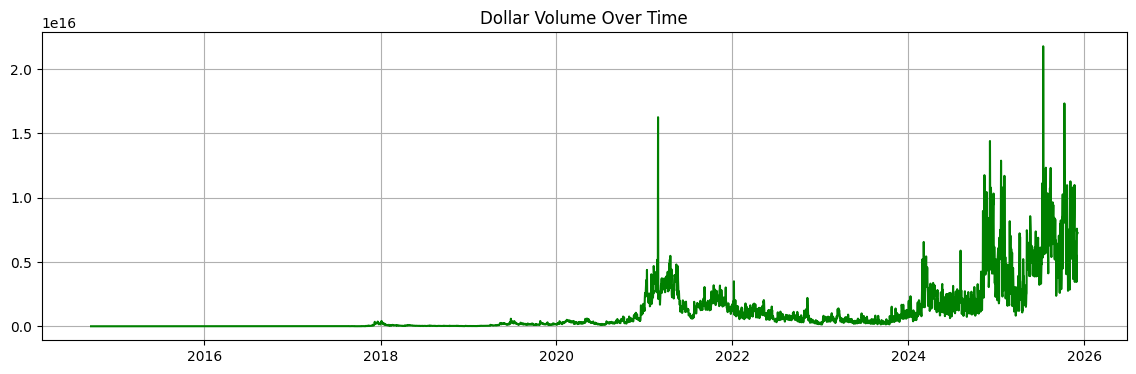

In [ ]:
# Trading Volume & Dollar Volume
data["dollar_volume"] = data["Close"] * data["Volume"]

plt.figure(figsize=(14,4))
plt.plot(data["Date"], data["Volume"], label="Raw Volume", alpha=0.7)
plt.title("Bitcoin Trading Volume Over Time")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(data["Date"], data["dollar_volume"], color="green", label="Dollar Volume (Close × Volume)")
plt.title("Dollar Volume Over Time")
plt.grid(True)
plt.show()

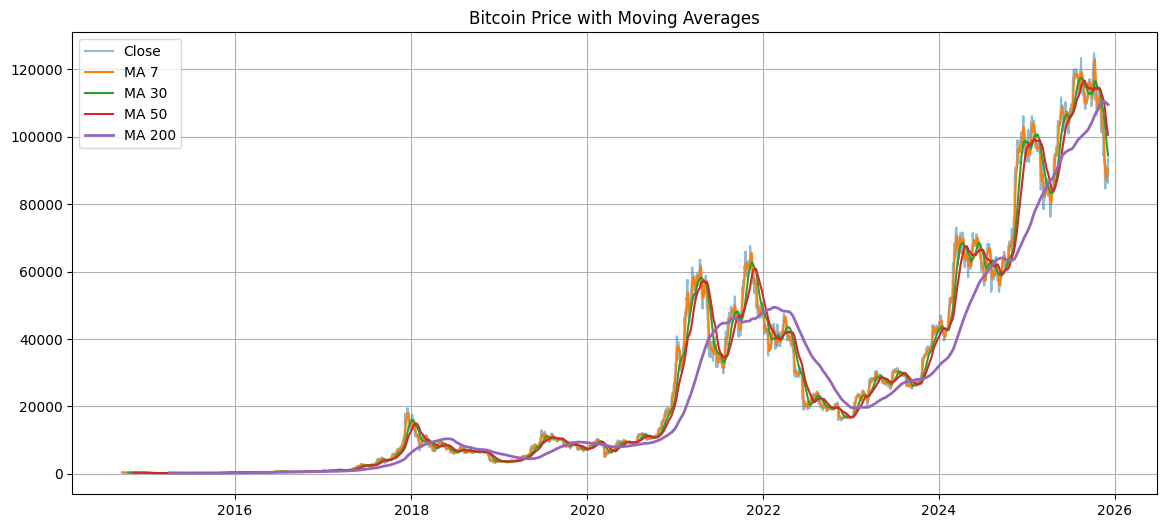

In [ ]:
# Moving Averages (Trend Analysis)
data["MA_7"] = data["Close"].rolling(7).mean()
data["MA_30"] = data["Close"].rolling(30).mean()
data["MA_50"] = data["Close"].rolling(50).mean()
data["MA_200"] = data["Close"].rolling(200).mean()

plt.figure(figsize=(14,6))
plt.plot(data["Date"], data["Close"], label="Close", alpha=0.5)
plt.plot(data["Date"], data["MA_7"], label="MA 7")
plt.plot(data["Date"], data["MA_30"], label="MA 30")
plt.plot(data["Date"], data["MA_50"], label="MA 50")
plt.plot(data["Date"], data["MA_200"], label="MA 200", linewidth=2)
plt.title("Bitcoin Price with Moving Averages")
plt.legend()
plt.grid(True)
plt.show()

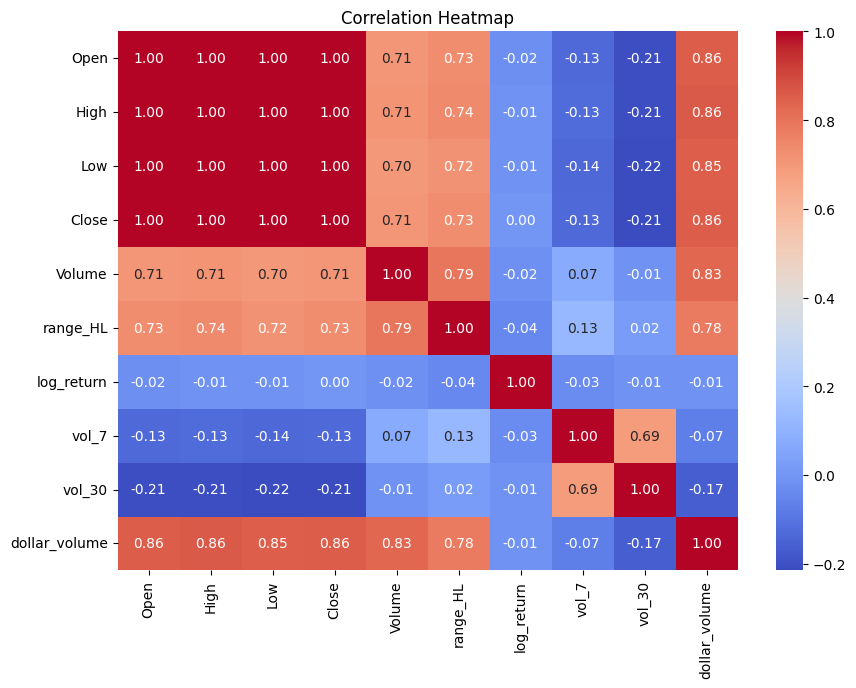

In [ ]:
# Correlation Heatmap (Technical Features Included)
corr_cols = ["Open","High","Low","Close","Volume","range_HL","log_return","vol_7","vol_30","dollar_volume"]

plt.figure(figsize=(10,7))
sns.heatmap(data[corr_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Stationarity Check (ADF Test)
adf_result = adfuller(data["log_return"].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("=> Log returns are stationary (reject H0).")
else:
    print("=> Log returns are NOT stationary (fail to reject H0).")

ADF Statistic: -19.44081957568969
p-value: 0.0
=> Log returns are stationary (reject H0).


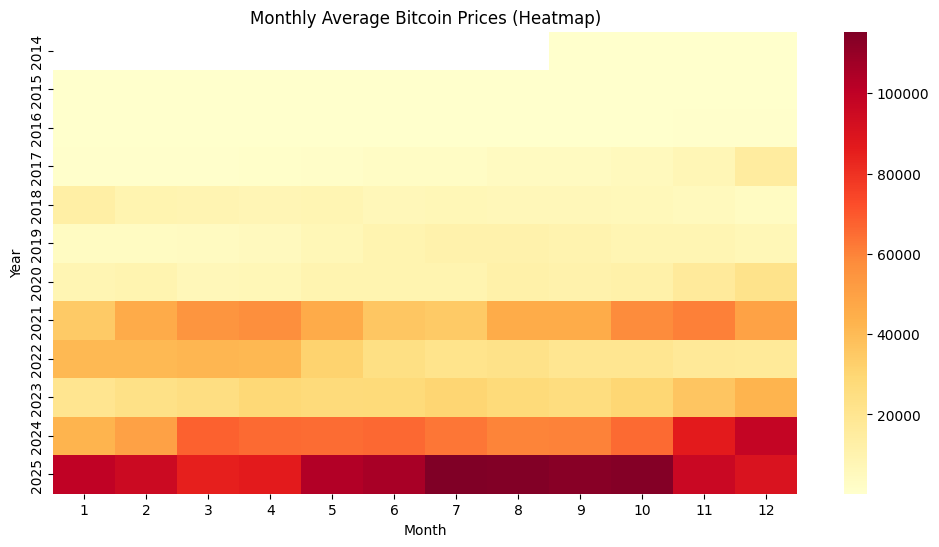

In [ ]:
# Monthly Average Close (Seasonality Insight)
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month

monthly_avg = data.groupby(["Year", "Month"])["Close"].mean().unstack()

plt.figure(figsize=(12,6))
sns.heatmap(monthly_avg, cmap="YlOrRd", annot=False)
plt.title("Monthly Average Bitcoin Prices (Heatmap)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

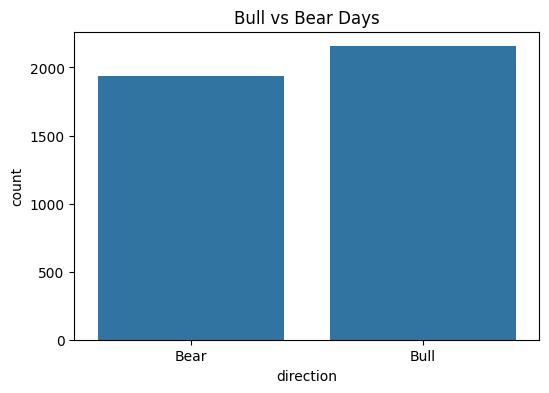

In [ ]:
# Candlestick Body Analysis (Bull/Bear Days)
data["body"] = data["Close"] - data["Open"]
data["direction"] = np.where(data["body"] >= 0, "Bull", "Bear")

plt.figure(figsize=(6,4))
sns.countplot(x="direction", data=data)
plt.title("Bull vs Bear Days")
plt.show()

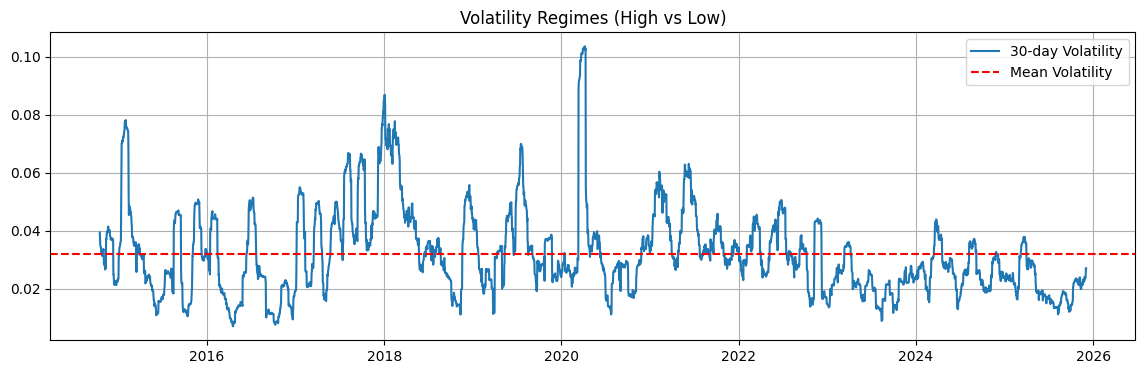

In [ ]:
# Volatility Regime Plot (High vs Low Vol Periods)
threshold = data["vol_30"].mean()

plt.figure(figsize=(14,4))
plt.plot(data["Date"], data["vol_30"], label="30-day Volatility")
plt.axhline(threshold, color="red", linestyle="--", label="Mean Volatility")
plt.title("Volatility Regimes (High vs Low)")
plt.legend()
plt.grid(True)
plt.show()